# Environment Setup

In [1]:
!pip install -i https://test.pypi.org/simple/ supervision==0.3.0
!pip install -q transformers
!pip install -q pytorch-lightning
!pip install -q roboflowO!pip install -q timm

Looking in indexes: https://test.pypi.org/simple/
  Attempting uninstall: supervision
    Found existing installation: supervision 0.16.0
    Uninstalling supervision-0.16.0:
      Successfully uninstalled supervision-0.16.0


In [1]:
import torch
!nvcc --version
TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)

import roboflow
import supervision
import transformers
import pytorch_lightning

print(
    "roboflow:", roboflow.__version__, 
    "; supervision:", supervision.__version__, 
    "; transformers:", transformers.__version__, 
    "; pytorch_lightning:", pytorch_lightning.__version__
)
     

nvcc: NVIDIA (R) Cuda compiler drivertorch:  2.1 ; cuda:  cu118

Copyright (c) 2005-2022 NVIDIA Corporation
Built on Wed_Sep_21_10:41:10_Pacific_Daylight_Time_2022
Cuda compilation tools, release 11.8, V11.8.89
Build cuda_11.8.r11.8/compiler.31833905_0


IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


roboflow: 1.1.12 ; supervision: 0.3.0 ; transformers: 4.35.2 ; pytorch_lightning: 2.1.2


# Load Model

In [2]:
import torch
from transformers import ConditionalDetrForObjectDetection, ConditionalDetrImageProcessor


# settings
DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
CHECKPOINT = 'microsoft/conditional-detr-resnet-50'
CONFIDENCE_TRESHOLD = 0.5
IOU_TRESHOLD = 0.8

image_processor = ConditionalDetrImageProcessor.from_pretrained(CHECKPOINT)
model = ConditionalDetrForObjectDetection.from_pretrained(CHECKPOINT)
model.to(DEVICE)

The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.


ConditionalDetrForObjectDetection(
  (model): ConditionalDetrModel(
    (backbone): ConditionalDetrConvModel(
      (conv_encoder): ConditionalDetrConvEncoder(
        (model): FeatureListNet(
          (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
          (bn1): ConditionalDetrFrozenBatchNorm2d()
          (act1): ReLU(inplace=True)
          (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
          (layer1): Sequential(
            (0): Bottleneck(
              (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
              (bn1): ConditionalDetrFrozenBatchNorm2d()
              (act1): ReLU(inplace=True)
              (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
              (bn2): ConditionalDetrFrozenBatchNorm2d()
              (drop_block): Identity()
              (act2): ReLU(inplace=True)
              (aa): Identity()
              (

# Create COCO data loaders

In [3]:
import os
import torchvision


# settings
dataset_location = f"D://Data//dataset"
ANNOTATION_FILE_NAME = "labels.json"
TRAIN_DIRECTORY = os.path.join(dataset_location, "train")
VAL_DIRECTORY = os.path.join(dataset_location, "val")
TEST_DIRECTORY = os.path.join(dataset_location, "test")


class CocoDetection(torchvision.datasets.CocoDetection):
    def __init__(
        self,
        dataset_directory_path: str,
        image_directory_path: str, 
        image_processor, 
        train: bool = True
    ):
        annotation_file_path = os.path.join(dataset_directory_path, ANNOTATION_FILE_NAME)
        super(CocoDetection, self).__init__(image_directory_path, annotation_file_path)
        self.image_processor = image_processor

    def __getitem__(self, idx):
        images, annotations = super(CocoDetection, self).__getitem__(idx)        
        image_id = self.ids[idx]
        annotations = {'image_id': image_id, 'annotations': annotations}
        encoding = self.image_processor(images=images, annotations=annotations, return_tensors="pt")
        pixel_values = encoding["pixel_values"].squeeze()
        target = encoding["labels"][0]

        return pixel_values, target


TRAIN_DATASET = CocoDetection(
    dataset_directory_path=f"{TRAIN_DIRECTORY}",
    image_directory_path=f"{TRAIN_DIRECTORY}//data", 
    image_processor=image_processor,
    train=True)
VAL_DATASET = CocoDetection(
    dataset_directory_path=f"{VAL_DIRECTORY}",
    image_directory_path=f"{VAL_DIRECTORY}//data", 
    image_processor=image_processor, 
    train=False)
TEST_DATASET = CocoDetection(
    dataset_directory_path=f"{TEST_DIRECTORY}",
    image_directory_path=f"{TEST_DIRECTORY}//data", 
    image_processor=image_processor, 
    train=False)

print("Number of training examples:", len(TRAIN_DATASET))
print("Number of validation examples:", len(VAL_DATASET))
print("Number of test examples:", len(TEST_DATASET))

loading annotations into memory...
Done (t=0.28s)
creating index...
index created!
loading annotations into memory...
Done (t=0.04s)
creating index...
index created!
loading annotations into memory...
Done (t=0.03s)
creating index...
index created!
Number of training examples: 25493
Number of validation examples: 2936
Number of test examples: 2913


# Visualize Data Entry

Image #21958


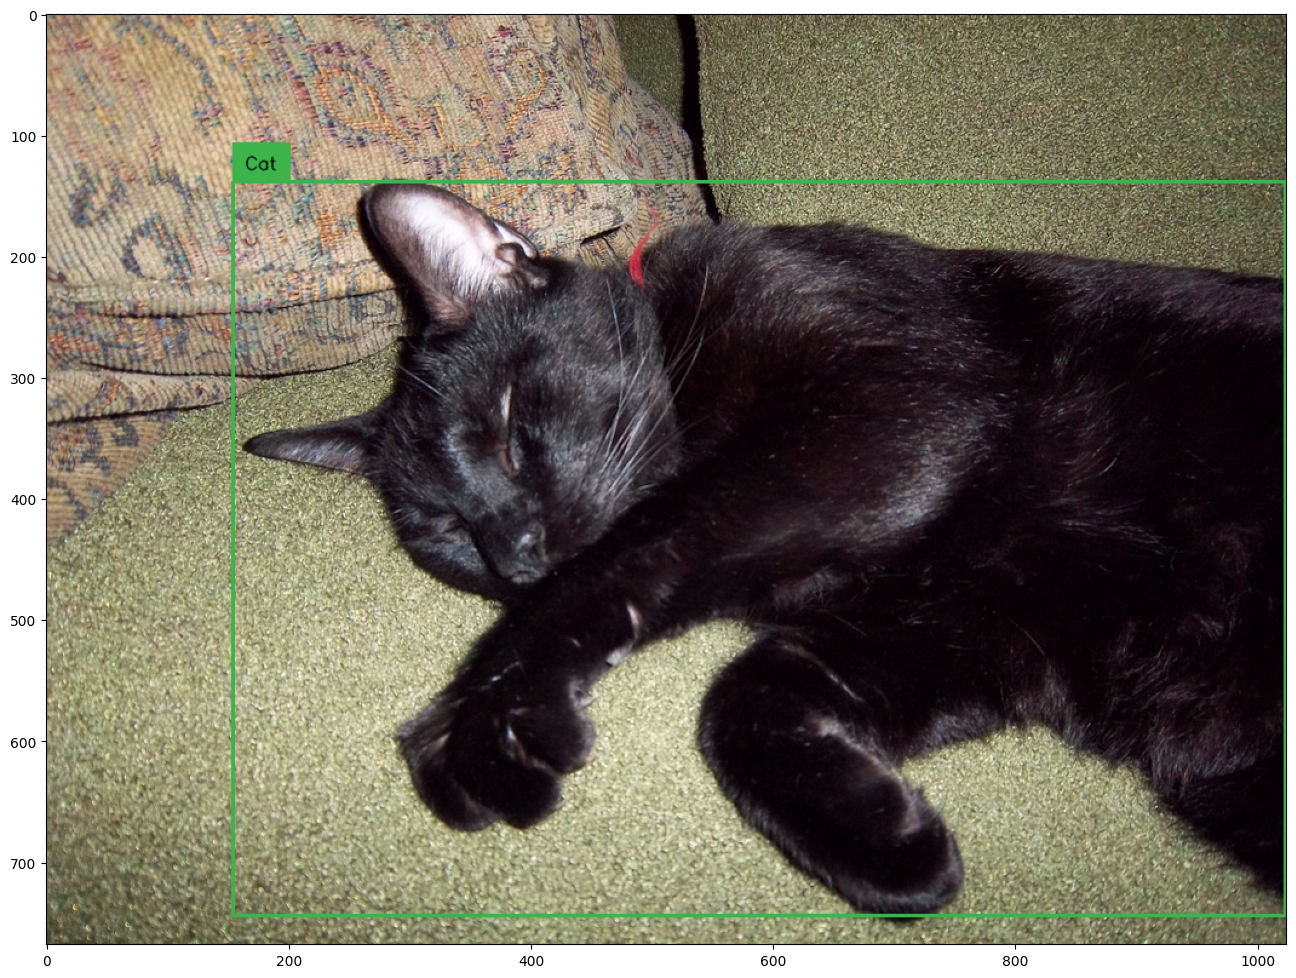

Image #15313


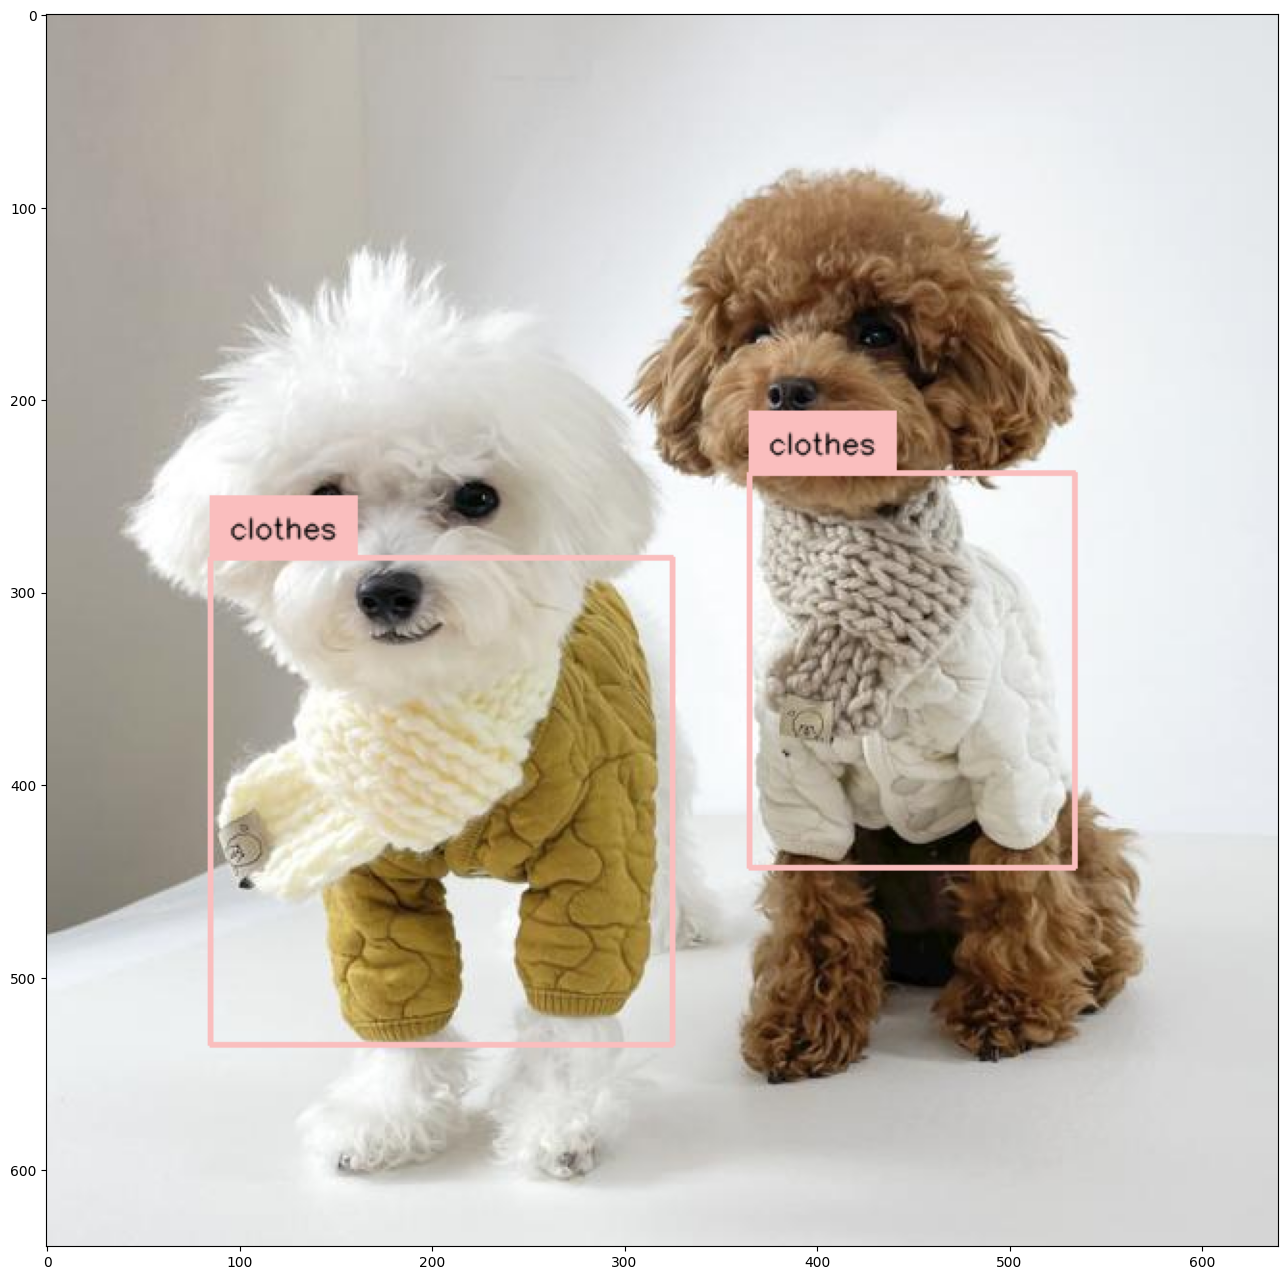

True

In [31]:
import random
import cv2
import numpy as np
import supervision as sv


# select random image
image_ids = TRAIN_DATASET.coco.getImgIds()
image_id = random.choice(image_ids)
print('Image #{}'.format(image_id))

# load image and annotatons 
image = TRAIN_DATASET.coco.loadImgs(image_id)[0]
annotations = TRAIN_DATASET.coco.imgToAnns[image_id]
image_path = os.path.join(TRAIN_DATASET.root, image['file_name'])
image = cv2.imread(image_path)

# annotate
detections = sv.Detections.from_coco_annotations(coco_annotation=annotations)

# we will use id2label function for training
categories = TRAIN_DATASET.coco.cats
id2label = {k: v['name'] for k,v in categories.items()}

labels = [
    f"{id2label[class_id]}" 
    for _, _, class_id, _ 
    in detections
]

box_annotator = sv.BoxAnnotator()
frame = box_annotator.annotate(scene=image, detections=detections, labels=labels)

%matplotlib inline  
sv.show_frame_in_notebook(image, (16, 16))
import random
import cv2
import numpy as np
import supervision as sv


# select random image
image_ids = TRAIN_DATASET.coco.getImgIds()
image_id = random.choice(image_ids)
print('Image #{}'.format(image_id))

# load image and annotatons 
image = TRAIN_DATASET.coco.loadImgs(image_id)[0]
annotations = TRAIN_DATASET.coco.imgToAnns[image_id]
image_path = os.path.join(TRAIN_DATASET.root, image['file_name'])
image = cv2.imread(image_path)

# annotate
detections = sv.Detections.from_coco_annotations(coco_annotation=annotations)

# we will use id2label function for training
categories = TRAIN_DATASET.coco.cats
id2label = {k: v['name'] for k,v in categories.items()}

labels = [
    f"{id2label[class_id]}" 
    for _, _, class_id, _ 
    in detections
]

box_annotator = sv.BoxAnnotator()
frame = box_annotator.annotate(scene=image, detections=detections, labels=labels)

%matplotlib inline  
sv.show_frame_in_notebook(image, (16, 16))

cv2.imwrite(f"D://{image_id}.jpg",frame)

In [18]:
from torch.utils.data import DataLoader

def collate_fn(batch):
    # DETR authors employ various image sizes during training, making it not possible 
    # to directly batch together images. Hence they pad the images to the biggest 
    # resolution in a given batch, and create a corresponding binary pixel_mask 
    # which indicates which pixels are real/which are padding
    pixel_values = [item[0] for item in batch]
    encoding = image_processor.pad(pixel_values, return_tensors="pt")
    labels = [item[1] for item in batch]
    return {
        'pixel_values': encoding['pixel_values'],
        'pixel_mask': encoding['pixel_mask'],
        'labels': labels
    }

TRAIN_DATALOADER = DataLoader(dataset=TRAIN_DATASET, collate_fn=collate_fn, batch_size=2, shuffle=True, pin_memory=True)
VAL_DATALOADER = DataLoader(dataset=VAL_DATASET, collate_fn=collate_fn, batch_size=4, pin_memory=True)
TEST_DATALOADER = DataLoader(dataset=TEST_DATASET, collate_fn=collate_fn, batch_size=4, pin_memory=True)

# Train Model with Pytorch Lightning

In [6]:
import pytorch_lightning as pl
from transformers import ConditionalDetrForObjectDetection
import torch


class Detr(pl.LightningModule):

    def __init__(self, lr, lr_backbone, weight_decay):
        super().__init__()
        self.model = ConditionalDetrForObjectDetection.from_pretrained(
            pretrained_model_name_or_path=CHECKPOINT, 
            num_labels=len(id2label),
            ignore_mismatched_sizes=True
        )
        
        self.lr = lr
        self.lr_backbone = lr_backbone
        self.weight_decay = weight_decay

    def forward(self, pixel_values, pixel_mask):
        return self.model(pixel_values=pixel_values, pixel_mask=pixel_mask)

    def common_step(self, batch, batch_idx):
        pixel_values = batch["pixel_values"]
        pixel_mask = batch["pixel_mask"]
        labels = [{k: v.to(self.device) for k, v in t.items()} for t in batch["labels"]]

        outputs = self.model(pixel_values=pixel_values, pixel_mask=pixel_mask, labels=labels)

        loss = outputs.loss
        loss_dict = outputs.loss_dict

        return loss, loss_dict

    def training_step(self, batch, batch_idx):
        loss, loss_dict = self.common_step(batch, batch_idx)     
        # logs metrics for each training_step, and the average across the epoch
        self.log("training_loss", loss)
        for k,v in loss_dict.items():
            self.log("train_" + k, v.item())

        return loss

    def validation_step(self, batch, batch_idx):
        loss, loss_dict = self.common_step(batch, batch_idx)     
        self.log("validation/loss", loss)
        for k, v in loss_dict.items():
            self.log("validation_" + k, v.item())
            
        return loss

    def configure_optimizers(self):
        # DETR authors decided to use different learning rate for backbone
        # you can learn more about it here: 
        # - https://github.com/facebookresearch/detr/blob/3af9fa878e73b6894ce3596450a8d9b89d918ca9/main.py#L22-L23
        # - https://github.com/facebookresearch/detr/blob/3af9fa878e73b6894ce3596450a8d9b89d918ca9/main.py#L131-L139
        param_dicts = [
            {
                "params": [p for n, p in self.named_parameters() if "backbone" not in n and p.requires_grad]},
            {
                "params": [p for n, p in self.named_parameters() if "backbone" in n and p.requires_grad],
                "lr": self.lr_backbone,
            },
        ]
        return torch.optim.AdamW(param_dicts, lr=self.lr, weight_decay=self.weight_decay)

    def train_dataloader(self):
        return TRAIN_DATALOADER

    def val_dataloader(self):
        return VAL_DATALOADER

**Start Tensorboard**

In [7]:
import torch
import torchvision
from torch.utils.tensorboard import SummaryWriter
from torchvision import datasets, transforms

# Writer will output to ./runs/ directory by default
writer = SummaryWriter()

transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
trainset = datasets.MNIST('mnist_train', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)
model = torchvision.models.resnet50(False)
# Have ResNet model take in grayscale rather than RGB
model.conv1 = torch.nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
images, labels = next(iter(trainloader))

grid = torchvision.utils.make_grid(images)
writer.add_image('images', grid, 0)
writer.add_graph(model, images)
writer.close()

%load_ext tensorboard
%tensorboard --logdir lightning_logs/

Using 'weights' as positional parameter(s) is deprecated since 0.13 and may be removed in the future. Please use keyword parameter(s) instead.
Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.


Launching TensorBoard...

In [8]:
model = Detr(lr=1e-4, lr_backbone=1e-5, weight_decay=1e-4)

# batch = next(iter(TRAIN_DATALOADER))
# outputs = model(pixel_values=batch['pixel_values'], pixel_mask=batch['pixel_mask'])

Some weights of ConditionalDetrForObjectDetection were not initialized from the model checkpoint at microsoft/conditional-detr-resnet-50 and are newly initialized because the shapes did not match:
- class_labels_classifier.weight: found shape torch.Size([91, 256]) in the checkpoint and torch.Size([2, 256]) in the model instantiated
- class_labels_classifier.bias: found shape torch.Size([91]) in the checkpoint and torch.Size([2]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
from pytorch_lightning import Trainer


torch.set_float32_matmul_precision('medium')
# settings
MAX_EPOCHS = 15

# pytorch_lightning < 2.0.0
# trainer = Trainer(gpus=1, max_epochs=MAX_EPOCHS, gradient_clip_val=0.1, accumulate_grad_batches=8, log_every_n_steps=5)

# pytorch_lightning >= 2.0.0
trainer = Trainer(devices=1, accelerator="gpu", max_epochs=MAX_EPOCHS)

trainer.fit(model)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type                              | Params
------------------------------------------------------------
0 | model | ConditionalDetrForObjectDetection | 43.4 M
------------------------------------------------------------
43.2 M    Trainable params
222 K     Non-trainable params
43.4 M    Total params
173.582   Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

In [6]:
import gc
gc.collect()
torch.cuda.empty_cache()